# Regulated Push-Pull Converter

Due to push-pull topology being prone to flux imbalances, this design uses current-mode PWM controller [UC3846](http://www.ti.com/lit/ds/symlink/uc3846.pdf).

## Push-pull topology

A typical current-mode half-bridge converter looks like this:

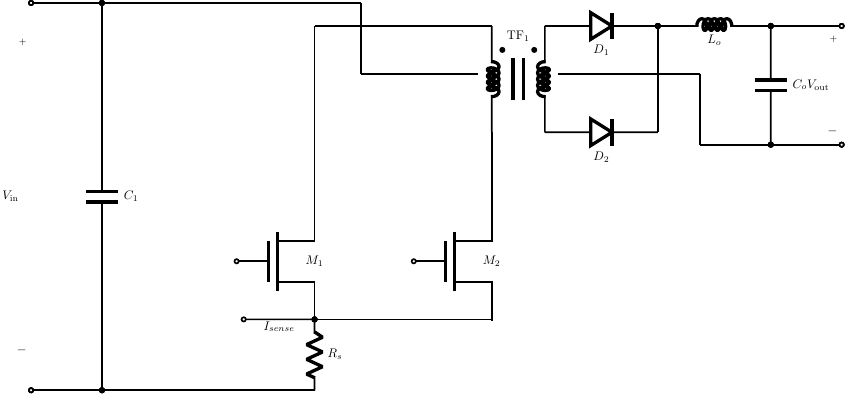

In [1]:
from IPython.display import display, Markdown, Image
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_topology_image()))

A push-pull converter can be viewed as an interleaved forward converter.
Also, fundamentally it is just a buck converter with a transformer
scaling the input voltage to a necessary level. Which means if
you ignore the transformer, it is just a buck converter built
around the inductor Lo. The output of the transformer can be rectified
by either a center-tapped or a full-bridge rectifier.

Some major pros and cons of the topology:

Pros:

* Provides all the benefits of a forward converter
  but with smaller input and output current ripple.
* Relatively easy to build. In most cases doesn't require any gate drivers.
* Can handle power levels of up to 1kW.

* Both full core reset and clamping leakage inductance spikes are
  achieved without the need for extra windings or energy-dissipating
  snubbers (although a snubber across the primary winding can still be handy).

Cons:

* Both switches experience theoretical voltage stress of $2 \times V_{in}$
  (Because when $V_{in}$ is applied to one half of the primary winding,
  it induces the same voltage in the other half, thus doubling the voltage
  applied to the non-conducting transistor).
  Normally the voltage stress is more than $2 \times V_{in}$ due to voltage
  spikes caused by the uncoupled leakage inductance of the transformer,
  unless dampened by a clamp or a snubber circuit.
  Such $2 \times V_{in}$ voltage stress makes push-pull converters less attractive for high input
  voltages such as european 240 VAC, requiring the use of expensive switches
  rated for 800-900V.
* Core flux imbalances can easily occur and accumulate, eventually leading to core
  saturation and destruction of the main switches, so mostly such supplies are build using current-mode control.

## Design parameters

In [2]:
from edcalc.component_types import Core, MOSFET
from edcalc.smps import OutputParams
from edcalc.components import cores

# Desired main switching frequency, Hz
# It may later be adjusted according to the real values of the capacitors/resistors of the oscillator,
# leading to a variable called 'F_sw'.
# It's a combined frequency of both switches, so each switch will turn on/off with a half of this frequency.
F_sw_desired = 100000

# Input voltage type: "AC" or "DC" 
V_in_type = "DC"
# Input voltage range (min, max)
V_in_range = (10, 13)

# Describe every output. The first one will be regulated.
out = [
    OutputParams(V=20, I=12, filter_core=cores['R33x17.8x11.1-MM52'], rectifier='center-tapped', Rt_JA_D=46, C=1000e-6, ESR=0.26),
]

# Expected efficiency
efficiency = 0.8
# Output inductor's ripple ratio (r = dI / I_L) in the worst conditions (when D = D_min)
# Must be less than 2 (to remain in CCM). Ideally, around 0.3-0.5
ripple = 0.4
# Desired duty cycle of a single switch at minimum input voltage.
# The actual value (calculated as 'D_max') will probably be slightly
# different depending on the components selected for the timing circuit.
D_max_desired = 0.8

### Magnetic elements ###
# The main transformer's core
core = cores['ETD44/22/15-N87']
# Current density, A/mm^2
I_density = 5
# Diameters of various wires available (to choose from), mm
wires_dia = [0.1, 0.25, 0.35, 0.45]
# Percentage the main transformer's uncoupled inductance,
# also known as leakage inductance. Typically it is 1-3% (0.01-0.03)
transformer_leakage_rate = 0.00241
# Peak flux density for the main transformer, Tesla
# 0.12T is far below a typical saturation density for most ferrites,
# but because in push-pull ΔB is rather large (in comparison with flyback),
# a lower value helps to reduce losses
B_pk = 0.12

### About the main switches ###
switch = MOSFET(C_rss=211e-12, C_iss=3247e-12, R_ds=8e-3, Rt_JC=0.75, Rt_JA=62)  # IRF3205
# Voltage driving the main switches (and powering the integrated driver if used), V
V_gs_sw = 12
# Max current driving the switches, A
I_drive_max = 0.4
#### Thermal design parameters ####
# Default ambient temperature
T_ambient = 25
# Case-to-heatsink temperature resistance of the main switch (thermal paste), °C/W
Rt_CS_sw = 0.5
# Heatsink-to-ambient temperature resistance of the heatsink installed on the main switch, °C/W
Rt_SA_sw = 17

In [3]:
import math
# Some convenient conversions
if V_in_type == 'AC':
    V_in_min = V_in_range[0] * math.sqrt(2)
    V_in_max = V_in_range[1] * math.sqrt(2)
else:
    V_in_min, V_in_max = V_in_range
P_out = [o.I * o.V for o in out]
P_out_sum = sum(P_out)
P_in = P_out_sum / efficiency

In [4]:
from edcalc.format import format_value, format_C, format_R, format_F, format_V, format_I, format_L, format_W, block_of_values, format_flux_density
from edcalc.eseries import nearest_e12, nearest_e24, find_esum
from edcalc.smps import coil_selection

## Input-output

In [5]:
print(f'Input power (with {efficiency*100}% efficiency): {format_W(P_in)}')
print('Output power:', format_W(P_out_sum))

Input power (with 80.0% efficiency): 300.0W
Output power: 240.0W


## UC3846 oscillator

these calculations are based on [this datasheet on UC3846 from TI](http://www.ti.com/lit/ds/symlink/uc3846.pdf). By setting deadtime to be $ T_d = {1 - D_{max} \over F_{sw}} $ we can derive both time-setting resistor and capacitor.

In [6]:
def uc3846_dead_time(R_t, C_t):
    return 145 * C_t * (7.5 / (7.5 - 3.6e3 / R_t))


def uc3846_frequency(R_t, C_t):
    return 2.2 / (R_t * C_t)

dead_time_required = (1 - D_max_desired) / F_sw_desired
R_t_approx = (145 * 2.2 / dead_time_required + F_sw_desired * 3.6e3 / 7.5) / F_sw_desired
C_t = nearest_e12(dead_time_required / (145 * (7.5 / (7.5 - 3.6e3 / R_t_approx))))
R_t_parts = find_esum(2.2 / (F_sw_desired * C_t))
R_t = sum(R_t_parts)
F_sw = uc3846_frequency(R_t, C_t)
dead_time = uc3846_dead_time(R_t, C_t)
D_max = 1 - dead_time * F_sw
display(block_of_values(
    ('Desired deadtime:', format_value(dead_time_required, "s")),
    ('Desired period:', f'{format_value(1 / F_sw_desired, "s")} (at {format_F(F_sw_desired)})'),
    ('Chain of time-setting resistors forming $R_T$:', ' + '.join([format_R(r) for r in R_t_parts])),
    ('Time-setting capacitor $C_T$', format_C(C_t)),
    ('Dead time actual:', format_value(dead_time, "s")),
    ('Max duty cycle:', f'{round(D_max, 4)} (please, check that the real circuit does not exceed that!)'),
    ('The actual switching frequency:', format_F(F_sw)),
))

<table><tr><td>Desired deadtime:</td><td>2.0us</td></tr>
<tr><td>Desired period:</td><td>10.0us (at 100.0kHz)</td></tr>
<tr><td>Chain of time-setting resistors forming $R_T$:</td><td>2.2kΩ</td></tr>
<tr><td>Time-setting capacitor $C_T$</td><td>10.0nF</td></tr>
<tr><td>Dead time actual:</td><td>1.85us</td></tr>
<tr><td>Max duty cycle:</td><td>0.8145 (please, check that the real circuit does not exceed that!)</td></tr>
<tr><td>The actual switching frequency:</td><td>100.0kHz</td></tr></table>

## The main transformer

In [7]:
# Each half of the primary winding conducts at a lower frequency (F_sw / 2)
# and so the duty cycle for it must be recalculated with respect to that frequency
D_max_halfw = D_max / 2

# The magnetic flux swings from -Bsat/2 to +Bsat/2
# In theory, we can use V_in_min while calculating the number of primary turns.
# However there is a possibility that during the startup time the converter
# will fail to adjust its duty cycle quickly enough to avoid saturation.
# So we're planning for the worst case scenario, which is V_in_max at D_max.
N_p = math.ceil(V_in_max * D_max / (F_sw * B_pk * core.A_e_mks))
L_p = core.A_L_mks * N_p**2
secondary_turns = [round(N_p * (o.V/D_max_halfw + o.full_diode_drop()) / V_in_min) for o in out]
L_secondary = [core.A_L_mks * ns**2 for ns in secondary_turns]
turns_ratios = [N_p / t for t in secondary_turns]
D_min_halfw_pri = (out[0].V + out[0].full_diode_drop()) * turns_ratios[0] / V_in_max
D_min = 2 * D_min_halfw_pri
dB_pk = V_in_max * D_max / (F_sw * N_p * core.A_e_mks)
display(block_of_values(
    ('Minimum duty cycle $D_{min}$', f'{round(D_min, 2)}'),
    ('Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)', format_flux_density(dB_pk, core.B_sat)),
))

<table><tr><td>Minimum duty cycle $D_{min}$</td><td>0.65</td></tr>
<tr><td>Maximum possible flux density at $V_{inMAX}$ (assuming $D_{max}$ is limited by the timing circuit!)</td><td>102.01mT, which is OK</td></tr></table>

### Primary winding RMS and flat-topped peak currents

based on A. Pressman:
> Current drawn from the DC input source... has ... ramp-on-a-step waveshape...
> To simplify calculation, the pulses in the figure are
> assumed to have an equivalent flat-topped waveshape whose amplitude
> $I_{pft}$ is the value of the current at the center of the ramp.

In [8]:

I_pft = P_out_sum / (efficiency * V_in_min * D_max)
I_pft_halfw = 2 * I_pft
I_pri_rms = I_pft * math.sqrt(D_max)
I_pri_rms_halfw = I_pft * math.sqrt(D_max_halfw)

display(block_of_values(
    (f'Flat-topped peak current entering the center of the primary winding', format_I(I_pft)),
    (f'RMS current at the center of the primary winding', format_I(I_pri_rms)),
    (f'Flat-topped peak current in each half of the primary winding', format_I(I_pft_halfw)),
    (f'RMS current going through each half of the primary windings', format_I(I_pri_rms_halfw)),
))

<table><tr><td>Flat-topped peak current entering the center of the primary winding</td><td>36.83A</td></tr>
<tr><td>RMS current at the center of the primary winding</td><td>33.24A</td></tr>
<tr><td>Flat-topped peak current in each half of the primary winding</td><td>73.66A</td></tr>
<tr><td>RMS current going through each half of the primary windings</td><td>23.5A</td></tr></table>

In [9]:
display(Markdown(f"\n### Primary winding (2 x {N_p} turns, center-tapped, {format_L(L_p)} each half)\n"))
display(coil_selection(F_sw, I_pri_rms_halfw, wires_dia, I_density, N_p, winding_area=core.W_a))

for i, o in enumerate(out):
    display(Markdown(f"\n### Secondary winding #{i + 1} ({'2 X ' if o.is_center_tapped else ''}"
          f"{secondary_turns[i]} turns, {format_L(L_secondary[i])})\n"))
    display(coil_selection(F_sw, out[i].I / (2 if o.is_center_tapped else 1), wires_dia, I_density, secondary_turns[i], winding_area=core.W_a))


### Primary winding (2 x 6 turns, center-tapped, 126.0uH each half)


With the RMS current of 23.5A and max current density of 5 $A/mm^2$, we need at least 4.7 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 6 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 599     | 4.7045 $mm^2$ | 43%            |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 96      | 4.7124 $mm^2$ | 43%            |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 49      | 4.7144 $mm^2$ | 43%            |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 30      | 4.7472 $mm^2$ | 44%            |


### Secondary winding #1 (2 X 30.0 turns, 3.15mH)


With the RMS current of 6.0A and max current density of 5 $A/mm^2$, we need at least 1.2 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 30.0 turns occupy |
|-----------|-----------|----------------|---------|---------------|-------------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 153     | 1.2017 $mm^2$ | 55%               |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 25      | 1.2272 $mm^2$ | 56%               |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 13      | 1.2507 $mm^2$ | 57%               |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 8       | 1.2659 $mm^2$ | 58%               |

## Output rectifiers

In [10]:
for i, o in enumerate(out):
    I_D_pft = o.I / D_min
    if o.rectifier is None:
        continue
    display(Markdown(f'\n### Output #{i + 1} ({o.rectifier} rectifier) ###'))
    if o.rectifier == 'center-tapped':
        n_diodes = 2
        V_R_D = 2 * V_in_max / turns_ratios[i] - o.V_D
        I_D_rms = o.I / 2
    elif o.rectifier == 'full-bridge':
        n_diodes = 4
        V_R_D = V_in_max / turns_ratios[i] - o.V_D
        I_D_rms = o.I
    else:
        raise ValueError(f'Unknown rectifier {o.rectifier}')
    P_D_out = I_D_rms * out[i].V_D
    
    to_print = [
        (f'Max reverse voltage on each of the {n_diodes} diodes', format_V(V_R_D)),
        (f'Peak current through each diode', format_I(I_D_pft)),
        ('RMS current per diode', format_I(I_D_rms)),
        ('Power dissipated on each of the diodes', format_value(P_D_out, "W")),
        ('Total power loss (all diodes combined)', format_value(n_diodes * P_D_out, "W")),
    ]
    if o.Rt_JA_D is not None:
        Tj_heatsink_D = T_ambient + P_D_out * o.Rt_JA_D
        to_print.append((f'Junction temperature:', format_value(Tj_heatsink_D, "°C")))
    display(block_of_values(*to_print))
    


### Output #1 (center-tapped rectifier) ###

<table><tr><td>Max reverse voltage on each of the 2 diodes</td><td>129.0V</td></tr>
<tr><td>Peak current through each diode</td><td>18.57A</td></tr>
<tr><td>RMS current per diode</td><td>6.0A</td></tr>
<tr><td>Power dissipated on each of the diodes</td><td>6.0W</td></tr>
<tr><td>Total power loss (all diodes combined)</td><td>12.0W</td></tr>
<tr><td>Junction temperature:</td><td>301.0°C</td></tr></table>

## Leakage inductance energy spikes

Each time one of the switches stops conducting, a huge voltage spike occurs at its drain. This is due to the leakage (uncoupled) inductance of the main transformer, which tries to keep the current flowing and thus raises the voltage across its ends. Left ignored, such spikes can destroy the switches.

### Option 1: RCD snubbers

These snubbers dump the parasitic energy burst into heat. They look like this (colored blue, virtual leakage inductance is red):

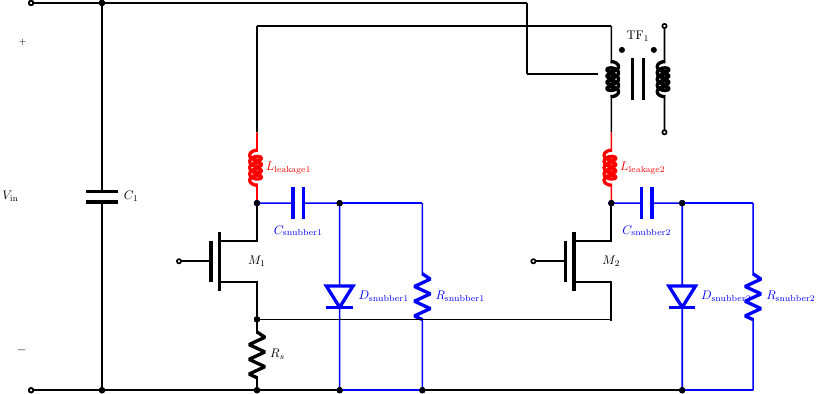

In [11]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_rcd_snubber_image()))

How they work:

* each $C_{snubber}$ absorbs about a half of the turn-off current spikes caused by the leakage inductance (designed that way)
* thus reduces transistor dissipation by slowing down drain raise time when the switch stops conducting and giving the switch more time to turn off at lower drain voltage. Important for BJT switches
* by dampening voltage spikes keeps them from destroying the switches

These calculations are based on chapter 11 from "Switching Power Supply Design" by A. Pressman. They are not very precise but practical enough.

Capacitance is $C = {Q \over V}$. We know that $V = 2 \times V_{in}$, and the charge is assumed to be $Q = I * T_{fall}$. If current is set to $I = I_{peak} / 2$, then $$ C_{snubber} = {T_{fall} {(I_{peak} / 2)} \over {2 V_{in}}} $$

Knowing $C_{snubber}$ we can calculate the resistance needed to "burn" the absorbed energy when the transistor is turned on. $R_{snubber}$ and $C_{snubber}$ form an [RC-circuit](https://en.wikipedia.org/wiki/RC_circuit) with time constant $\tau = R C$ which can be discharged to 5% of its original voltage in time equal $3 \tau$. So, if we assume $ T_{on} = 3 \tau = 3 R C $ we get $$ R_{snubber} = {T_{on\_min} \over {3 C_{snubber}}} = { D_{min} \over {3 F_{sw} C_{snubber}}}$$

In [12]:
# Here we assume that turn-on and turn-off periods for a MOSFET are equal
I_C_snubber = I_pft_halfw / 2
T_fall = switch.gate_drive_charge(V_in_max, V_gs_sw) / I_drive_max
C_snubber = nearest_e12(I_C_snubber * T_fall / (2 * V_in_min))
R_snubber = nearest_e12(D_min / (3 * F_sw * C_snubber))
L_p_leakage = L_p * transformer_leakage_rate
Z_LC_snubber = math.sqrt(L_p_leakage / C_snubber)
V_spike_sw = 2 * V_in_max + Z_LC_snubber * I_C_snubber
E_snubber = C_snubber * (2 * V_in_max)**2 / 2
P_snubber = E_snubber * F_sw
display(block_of_values(
    ('Assumed $T_{fall}$  time', format_value(T_fall, "s")),
    ('Amplitude of the turn-off voltage spike', format_V(V_spike_sw)),
    ('$C_{snubber}$', format_C(C_snubber)),
    ('$R_{snubber}$', format_R(R_snubber)),
    ('Power dissipated through $R_{snubber}$ each cycle', format_W(P_snubber)),
))

<table><tr><td>Assumed $T_{fall}$  time</td><td>104.27ns</td></tr>
<tr><td>Amplitude of the turn-off voltage spike</td><td>73.84V</td></tr>
<tr><td>$C_{snubber}$</td><td>180.0nF</td></tr>
<tr><td>$R_{snubber}$</td><td>12.0Ω</td></tr>
<tr><td>Power dissipated through $R_{snubber}$ each cycle</td><td>6.08W</td></tr></table>

### Option 2: Isolated passive lossless clamps

This clamp accumulates the energy stored in the leakage inductance and recovers it to the input of the supply. It uses two independent inductances $L_s$.

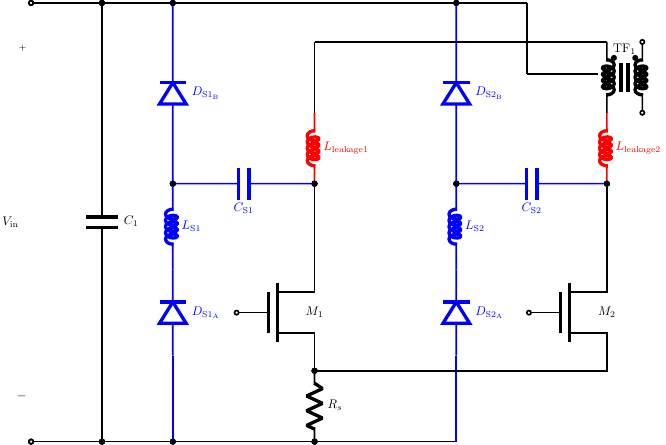

In [13]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_lossless_clamp_image()))

The circuit works by dumping the energy of the leakage inductance into a capacitor $C_S$, which is already "pre-charged" to $V_{in}$. The capacitor is selected so that the energy dump doesn't raise its voltage beyound a certail limit `V_clamp_max`. Next time the transistor is conducting, it connects the capacitor to an intermediate inductance $L_S$ during the time $T_{ON}$ (which can be as long as $D_{max} / F_{sw}$). Again, the inductance of $L_S$ is selected so that the capacitor will be only partially discharged to the "pre-charged" voltage $V_{in}$, again. Once the transistor is off again, the inductance $L_S$ will freewheel its current into the input power line through the upper and lower diodes. At the same time, $C_S$ will absorb another energy spike, and the cycle will be repeated. Because $C_S$ stays "pre-charged" to at least $V_{in}$, this keeps diode $D_{SB}$ off when another side of the circuit is conducting.

The calculations below are just rough estimations that seem to work well enough.

In [14]:
import importlib; importlib.reload(edcalc.smps)
clamp1_components, clamp1_info = edcalc.smps.non_dissipative_isolated_clamp(
    V_in_min, V_in_max, I_pri_pk=I_pft_halfw, L_leakage=L_p * transformer_leakage_rate, T_clamp_on=D_min/F_sw, T_clamp_off=(2 - D_min) / F_sw, V_ripple=0.1)
display(block_of_values(*clamp1_info))

<table><tr><td>Peak current through the upper diode $D_{SB}$</td><td>77.76A</td></tr>
<tr><td>RMS current through the upper diode $D_{SB}$</td><td>8.24A</td></tr>
<tr><td>Leakage inductance</td><td>303.66nH</td></tr>
<tr><td>Max drain-source voltage:</td><td>27.3V</td></tr>
<tr><td>Min pre-charged voltage on $C_S$</td><td>10.0V</td></tr>
<tr><td>Minimum $L_S$</td><td>26.42uH</td></tr>
<tr><td>Minimum $C_S$</td><td>82.0uF</td></tr>
<tr><td>Peak current through $C_S$</td><td>73.66A</td></tr>
<tr><td>Power recovered by one clamps is</td><td>41.19W</td></tr>
<tr><td>$L_s$ peak-to-peak ripple $\Delta I$</td><td>4.1A</td></tr>
<tr><td>$L_s$ RMS (center-ramp) current $I_{Ls}$</td><td>3.95A</td></tr>
<tr><td>$L_s$ peak current</td><td>6.0A</td></tr>
<tr><td>Max drain-source voltage/reverse voltage across each of the diodes:</td><td>27.3V</td></tr></table>

### Option 3: Nondissipative clamping through recovery reset windings

This method is described in ["Nondissipative Clamping Benefits DC-DC Converters" by By Viktor D. Vogman](https://www.powerelectronics.com/content/article/21857520/nondissipative-clamping-benefits-dcdc-converters) ([pdf version](static/papers/non-dissipative-clamping.pdf)). Unlike the 2nd option, it uses only two diodes, eliminates the extra inductors, however requires a copy of the primary winding on the main transformer called recovery windings (with the same number of turns although a thinner wire).

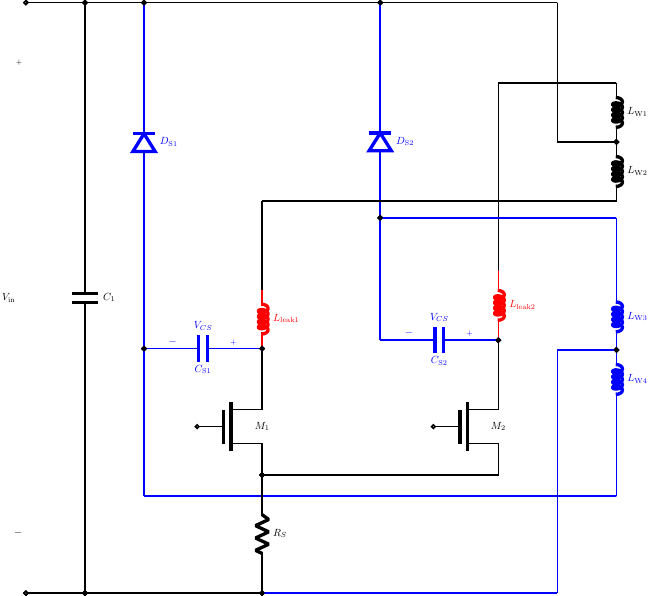

In [15]:
import edcalc.schematics
display(Image(edcalc.schematics.push_pull_coupled_lossless_clamp_image()))

Windings $L_{W1}$, $L_{W2}$, $L_{W3}$ and $L_{W4}$ are all wounded on the same core and in the same direction (say, upside-down as shown on the schematic) and have the same number of turns of the primary winding. The secondary windings are omitted on this diagram.

In [16]:
clamp2_components, clamp2_info = edcalc.smps.non_dissipative_coupled_clamp(
    V_in_min, V_in_max, I_pri_pk=I_pft_halfw, L_leakage=L_p * transformer_leakage_rate, T_clamp_on=D_min/F_sw, T_clamp_off=(2 - D_min) / F_sw, V_ripple=0.1)
display(block_of_values(*clamp2_info))
display(Markdown(f'#### Extra windings 2 x {N_p} turns, just like the primary'))
display(coil_selection(F_sw, clamp2_components.I_L_rec_rms, wires_dia, I_density, N_p, winding_area=core.W_a))

<table><tr><td>Minimum $C_S$</td><td>82.0uF</td></tr>
<tr><td>RMS current of the recovery winding</td><td>17.22A</td></tr>
<tr><td>Resonant frequency (must be $<< F_{sw}$)</td><td>7.84uHz</td></tr>
<tr><td>Max drain-source voltage:</td><td>26.0V</td></tr>
<tr><td>$D_S$ reverse voltage</td><td>26.0V</td></tr>
<tr><td>$D_S$ peak current</td><td>73.66V</td></tr>
<tr><td>$D_S$ RMS current</td><td>4.12A</td></tr></table>

#### Extra windings 2 x 6 turns, just like the primary

With the RMS current of 17.22A and max current density of 5 $A/mm^2$, we need at least 3.44 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 6 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 439     | 3.4479 $mm^2$ | 32%            |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 71      | 3.4852 $mm^2$ | 32%            |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 36      | 3.4636 $mm^2$ | 32%            |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 22      | 3.4813 $mm^2$ | 32%            |

## Main switches

In [17]:
# Thermal analysis
T_rise = switch.gate_drive_charge(V_in_max, V_gs_sw) / I_drive_max
P_heat_sw = switch.R_ds * I_pri_rms_halfw**2
Tj_heatsink_sw = T_ambient + P_heat_sw * (switch.Rt_JC + Rt_CS_sw + Rt_SA_sw)
Tj_bare_sw = T_ambient + P_heat_sw * (switch.Rt_JA)
R_gate_sw = V_gs_sw / I_drive_max

display(block_of_values(
    (f'Gate resistors:', format_R(R_gate_sw)),
    (f'Rise time', format_value(T_rise, 's')),
    ('Junction temperature with the heatsink', format_value(Tj_heatsink_sw, '˚C')),
    ('Junction temperature without any cooling', format_value(Tj_bare_sw, '˚C')),
    ('Max drain-source voltage:', 'depends on the clamp/snubber chosen'),
    (f'RMS current', format_I(I_pri_rms_halfw)),
    (f'Peak current', format_I(I_pft_halfw)),
))

<table><tr><td>Gate resistors:</td><td>30.0Ω</td></tr>
<tr><td>Rise time</td><td>104.27ns</td></tr>
<tr><td>Junction temperature with the heatsink</td><td>105.66˚C</td></tr>
<tr><td>Junction temperature without any cooling</td><td>299.02˚C</td></tr>
<tr><td>Max drain-source voltage:</td><td>depends on the clamp/snubber chosen</td></tr>
<tr><td>RMS current</td><td>23.5A</td></tr>
<tr><td>Peak current</td><td>73.66A</td></tr></table>

## Output filters

Please, note that according to A. Pressman:

> The output capacitor Co is selected to meet the maximum output ripple
voltage specification. In Section 1.3.7 it was shown that the output
ripple is determined almost completely by the magnitude of the ESR
(equivalent series resistance, Ro ) in the filter capacitor and not by the
magnitude of the capacitor itself.

The theory is covered in ["Understanding Buck Power Stages"](static/papers/slva057-buck-power-stages.pdf)
by Everett Rogers
and in [Analog Circuit Design Volume 2: Immersion in the Black Art of Analog Design](https://books.google.ru/books?id=H9rAU4Rf--YC&lpg=PA108&pg=PA108#v=onepage&q&f=false)
by Bob Dobkin and Jim Williams.

In [18]:
L_out, C_out, ESR_C_out = [], [], []
for i, o in enumerate(out):
    display(Markdown(f'\n###  Output #{i+1}: ###\n'))
    _power_portion = P_out[i] / P_out_sum
    _I_out_pft = _power_portion * I_pft_halfw * turns_ratios[i]
    V_s_in_min = V_in_min / turns_ratios[i] - o.full_diode_drop()
    V_s_in_max = V_in_max / turns_ratios[i] - o.full_diode_drop()
    output_suggestions, extra_info = edcalc.smps.buck_output_params(
        F_sw, V_s_in_min, V_s_in_max, _I_out_pft, D_min, D_max, o.V, o.I, ripple, o.filter_core, o.C_ripple)
    display(block_of_values(*extra_info))
    display(Markdown('### The winding'))
    display(coil_selection(F_sw, o.I, wires_dia, I_density, output_suggestions.N))
    L_out.append(output_suggestions.L)
    C_out.append(output_suggestions.C if o.C is None else o.C)
    ESR_C_out.append(output_suggestions.ESR if o.ESR is None else o.ESR)


###  Output #1: ###


<table><tr><td>Output voltage</td><td>20.0V</td></tr>
<tr><td>Output current</td><td>12.0A</td></tr>
<tr><td>Output voltage ripple (0.1%)</td><td>20.0mV</td></tr>
<tr><td>Output inductor</td><td>45.98uH, 22 turns</td></tr>
<tr><td>Inductor mode</td><td>continuous</td></tr>
<tr><td>Inductor's peak flux density</td><td>382.49mT, which is OK</td></tr>
<tr><td>Recommended minimum capacitor:</td><td>300.0uF</td></tr>
<tr><td>Max ESR of this capacitor should be</td><td>4.17mΩ</td></tr>
<tr><td>Output capacitor RMS current</td><td>1.39A</td></tr>
<tr><td>Such capacitor will dissipate</td><td>8.0mW</td></tr>
<tr><td>Desirable inductor</td><td>45.98uH, 22 turns</td></tr>
<tr><td>Inductor's peak current:</td><td>14.4A</td></tr></table>

### The winding

With the RMS current of 12.0A and max current density of 5 $A/mm^2$, we need at least 2.4 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.42 $ mm $ (0.14 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 22 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 306     | 2.4033 $mm^2$ |                 |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 49      | 2.4053 $mm^2$ |                 |
| 0.35 $mm$ | 0.35 $mm$ | OK             | 25      | 2.4053 $mm^2$ |                 |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 16      | 2.5319 $mm^2$ |                 |